In [157]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import thinkstats2
import thinkplot
import math
import statsmodels.formula.api as smf
import seaborn as sns

In [158]:
# define functions that for some reason didn't otherwise work with the import in the cell above

def Cov(xs, ys, meanx=None, meany=None):
    """Computes Cov(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values
        meanx: optional float mean of xs
        meany: optional float mean of ys

    Returns:
        Cov(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov


def Corr(xs, ys):
    """Computes Corr(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values

    Returns:
        Corr(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = MeanVar(xs)
    meany, vary = MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / math.sqrt(varx * vary)

    return corr

def MeanVar(xs, ddof=0):
    """Computes mean and variance.

    Based on http://stackoverflow.com/questions/19391149/
    numpy-mean-and-variance-from-single-function

    xs: sequence of values
    ddof: delta degrees of freedom
    
    returns: pair of float, mean and var
    """
    xs = np.asarray(xs)
    mean = xs.mean()
    s2 = Var(xs, mean, ddof)
    return mean, s2

def Var(xs, mu=None, ddof=0):
    """Computes variance.

    xs: sequence of values
    mu: option known mean
    ddof: delta degrees of freedom

    returns: float
    """
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [159]:
# Import the dataset that was saved from https://www2.census.gov/programs-surveys/acs/data/pums/2018/1-Year/
df = pd.read_csv(r'C:\Users\rreichhard.PAYPALCORP\Desktop\Bellevue\DSC 530\Final Project\Arizona Community Survey.csv')

In [160]:
# Read the data into a dataframe & keeping only the desired columns
# Apply the adjustment factor to the earnings attribute to account for current dollars
# Clean the data by dropping NA's and any rows where no income was reported

data = pd.DataFrame(df, columns=['ADJINC', 'AGEP', 'MAR', 'SCHL', 'OCCP', 'PERNP'])
data['ADJINC_PERNP'] = data.ADJINC * data.PERNP / 1000000
clean_data = data[data.ADJINC_PERNP != 0]
clean_data = clean_data.dropna()

In [161]:
# Adjusting the data to be strings as needed
clean_data['SCHL']= clean_data.SCHL.astype(str)
clean_data['MAR']= clean_data.MAR.astype(str)
clean_data.head()
# I saved a csv of this to my machine to for safe keeping
# clean_data.to_csv(r'C:\Users\rreichhard.PAYPALCORP\Desktop\Bellevue\DSC 530\Final Project\Clean_Data.csv')

,ADJINC,AGEP,MAR,SCHL,OCCP,PERNP,ADJINC_PERNP
4,1013097,19,5,16.0,4150.0,2500.0,2532.7425
5,1013097,30,1,19.0,7840.0,30000.0,30392.9100
7,1013097,45,4,19.0,6355.0,12000.0,12157.1640
11,1013097,21,5,16.0,8140.0,98000.0,99283.5060
12,1013097,20,5,16.0,2016.0,5000.0,5065.4850


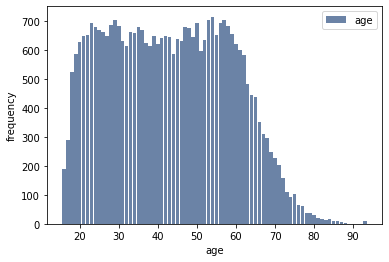

<Figure size 576x432 with 0 Axes>

In [162]:
# Histogram of Respondent Age
hist = thinkstats2.Hist(clean_data.AGEP, label='age')
thinkplot.Hist(hist)
thinkplot.Show(xlabel='age', ylabel='frequency')

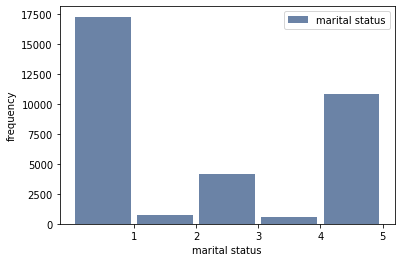

<Figure size 576x432 with 0 Axes>

In [163]:
# Histogram of Respondent Marital Status
# 1 - Married, 2 - Widowed, 3 - Divorced, 4 - Separated, 5 - Single/Never married
hist = thinkstats2.Hist(clean_data.MAR, label='marital status')
thinkplot.Hist(hist)
thinkplot.Show(xlabel='marital status', ylabel='frequency')

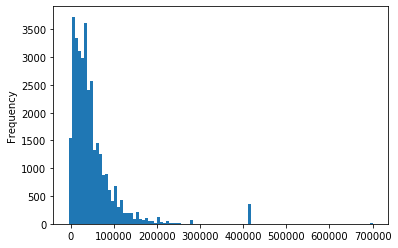

In [164]:
# Histogram of Respondent Income adjusted for inflation
clean_data.ADJINC_PERNP.plot.hist(bins=100)

In [165]:
# Calculating & printing the mean, mode, & variance of age & earnings
agep_mean = clean_data.AGEP.mean()
agep_mode = clean_data.AGEP.mode()
agep_spread = clean_data.AGEP.var()
earn_mean = clean_data.ADJINC_PERNP.mean()
earn_mode = clean_data.ADJINC_PERNP.mode()
earn_spread = clean_data.ADJINC_PERNP.var()

In [166]:
print('For age, the mean is:', agep_mean, ', the mode is:', agep_mode, ', and the spread is:', agep_spread)

For age, the mean is: 42.935737939676 , the mode is: 0    54
dtype: int64 , and the spread is: 237.93094992308593


In [167]:
print('For total individual earnings, the mean is:', earn_mean, ', the mode is:', earn_mode, ', and the spread is:', earn_spread)

For total individual earnings, the mean is: 48178.35549535591 , the mode is: 0    30392.91
dtype: float64 , and the spread is: 3344493984.389552


In [168]:
# For Marital status, I wanted to display the frequency via histogram as well as percentage of total
mar_count = pd.value_counts(clean_data.MAR)
percentage_list = []
for value in mar_count:
    percentage = value / len(clean_data.MAR)*100
    percentage_list.append(percentage)

mar_count=mar_count.to_frame()
mar_count['percentage'] = percentage_list
mar_count

,MAR,percentage
1,17254,51.475283
5,10818,32.274233
3,4174,12.452639
2,714,2.130135
4,559,1.667711


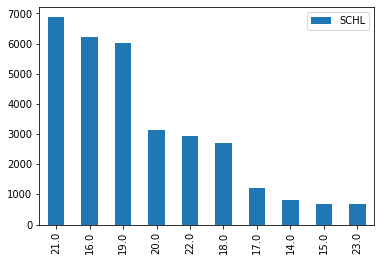

In [169]:
# For Educational Attainment, I wanted to display the frequency via histogram as well as percentage of total
schl_count = pd.value_counts(clean_data.SCHL)
percentage_list = []
for value in schl_count:
    percentage = value / len(clean_data.SCHL)*100
    percentage_list.append(percentage)

schl_count=schl_count.to_frame()
schl_count[:10].plot(kind='bar')
schl_count['percentage'] = percentage_list


In [170]:
schl_count[:10]

,SCHL,percentage
21.0,6866,20.483905
16.0,6215,18.541723
19.0,6004,17.912229
20.0,3119,9.305170
22.0,2930,8.741311
18.0,2691,8.028282
17.0,1220,3.639727
14.0,818,2.440407
15.0,695,2.073451
23.0,669,1.995883


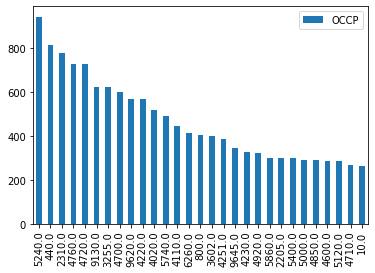

In [171]:
# For Occupation, I wanted to display the frequency via histogram as well as percentage of total
occp_count = pd.value_counts(clean_data.OCCP)
percentage_list = []
for value in occp_count:
    percentage = value / len(clean_data.OCCP)*100
    percentage_list.append(percentage)

occp_count=occp_count.to_frame()
occp_count[:10].plot(kind='bar')
occp_count['percentage'] = percentage_list

In [172]:
occp_count[:10]

,OCCP,percentage
5240.0,944,2.816313
440.0,817,2.437424
2310.0,779,2.324055
4760.0,731,2.180853
4720.0,727,2.168919
9130.0,623,1.858647
3255.0,623,1.858647
4700.0,603,1.798980
9620.0,571,1.703511
4220.0,569,1.697545


In [173]:
# Adjusting the occupation code to be read as an integer
# Then creating a new variable mapping each occupation by count and if less than 15, it got coded as '-999'
clean_data['OCCP'] = clean_data['OCCP'].astype(int) 
clean_data['occp_1'] = clean_data.OCCP.map(dict(zip(clean_data['OCCP'].value_counts().index, range(1, len(clean_data.OCCP.value_counts().index)+1))))
clean_data.head(16)
clean_data.sort_values('occp_1',ascending=1)
clean_data['occp_new']=clean_data['OCCP']
clean_data.loc[clean_data['occp_1']>15, 'occp_new']=-999

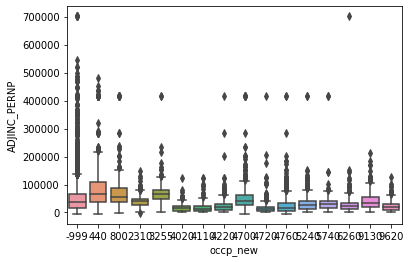

In [174]:
# Box & Whisker Plot for Occupation
clean_data.occp_new.value_counts()
sns.boxplot(y='ADJINC_PERNP',x='occp_new',data=clean_data)

In [175]:
# generate a PMF comparing the incomes of respondents with a bachelor's degree (value of 21 for SCHL) 
# and those with a high school diploma (value of 16 for SCHL)

bach = clean_data[clean_data.SCHL == '21.0']
hsdip = clean_data[clean_data.SCHL == '16.0']
mast = clean_data[clean_data.SCHL == '22.0']
bach_pmf = thinkstats2.Pmf(bach.ADJINC_PERNP, label='bachelor earnings')

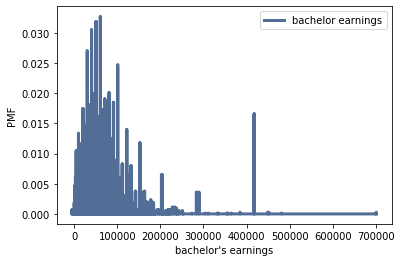

In [176]:
thinkplot.Pmf(bach_pmf)
thinkplot.Config(xlabel='bachelor\'s earnings', ylabel='PMF')

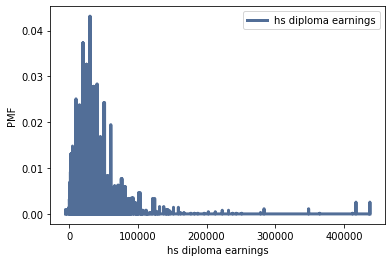

In [177]:
hsdip_pmf = thinkstats2.Pmf(hsdip.ADJINC_PERNP, label='hs diploma earnings')
thinkplot.Pmf(hsdip_pmf)
thinkplot.Config(xlabel='hs diploma earnings', ylabel='PMF')

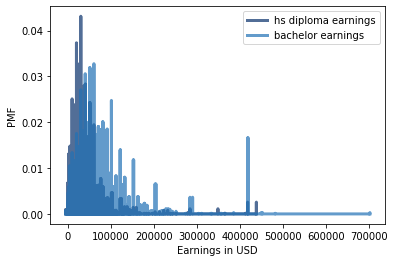

In [178]:
# PMF comparing the earnings of respondents with a bachelor's degree and respondents with a hs diploma
thinkplot.Pmfs([hsdip_pmf, bach_pmf])
thinkplot.Config(xlabel='Earnings in USD', ylabel='PMF')

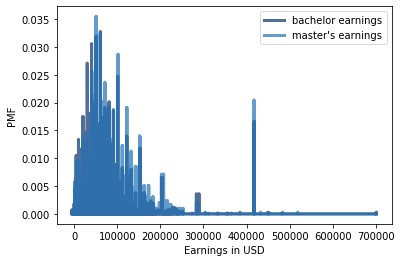

In [179]:
# PMF comparing the earnings of respondents with a bachelor's degree and respondents with a master's degree
mast_pmf = thinkstats2.Pmf(mast.ADJINC_PERNP, label='master\'s earnings')
thinkplot.Pmfs([bach_pmf, mast_pmf])
thinkplot.Config(xlabel='Earnings in USD', ylabel='PMF')

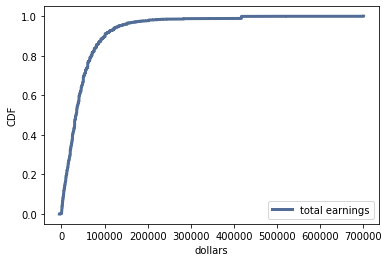

<Figure size 576x432 with 0 Axes>

In [180]:
cdf = thinkstats2.Cdf(clean_data.ADJINC_PERNP, label='total earnings')
thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='dollars', ylabel='CDF')

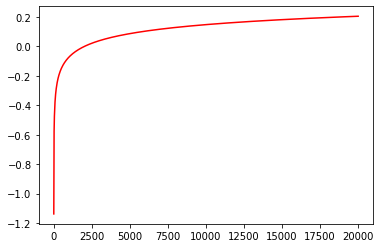

In [181]:
# Pareto distribution of income
x = np.linspace(1, 20000,1000)
y = 1-(x/2000)**(-.1)
plt.plot(x,y, 'r')
plt.show()

In [183]:
# Changing the educational attainment variable to be read as a float
clean_data['SCHL']= clean_data.SCHL.astype(float)

In [184]:
# Creating samples of adjusted earnings, age, and education for the scatter plots
sample = thinkstats2.SampleRows(clean_data, 5000)
pernp = sample.ADJINC_PERNP
sample_age = sample.AGEP
schl = sample.SCHL

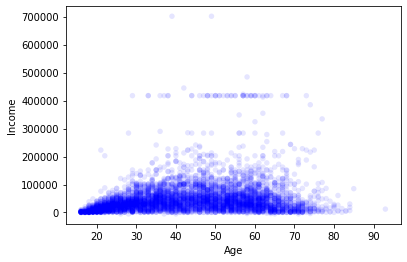

<Figure size 576x432 with 0 Axes>

In [200]:
# Scatterplot of age vs adjusted earnings
thinkplot.Scatter(sample_age, pernp, alpha=.1)
thinkplot.Show(ylabel='Income', xlabel='Age')

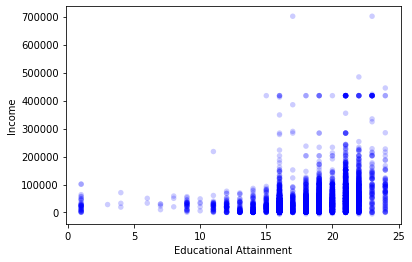

<Figure size 576x432 with 0 Axes>

In [186]:
# Scatterplot of education vs adjusted earnings
thinkplot.Scatter(schl, pernp, alpha=.2)
thinkplot.Show(ylabel='Income', xlabel='Educational Attainment')

In [187]:
# Covariance & Pearson's Correlation for both scatter plots
Cov(sample_age, pernp)

181284.04250392158

In [188]:
Corr(pernp, sample_age)

0.1987079921150039

In [189]:
Cov(pernp, schl)

50390.10164914594

In [190]:
Corr(pernp, schl)

0.2711966977518842

In [191]:
# Linear Regression with Adjusted Income as the dependent variable and educational attainment and age 
# as the independent variables

formula = 'ADJINC_PERNP ~ SCHL + AGEP'
model = smf.ols(formula, data=clean_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADJINC_PERNP   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1962.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:28:24   Log-Likelihood:            -4.1325e+05
No. Observations:               33519   AIC:                         8.265e+05
Df Residuals:                   33516   BIC:                         8.265e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.321e+04   1823.578    -34.664      0.000   -6.68e+04   -5.96e+04
SCHL        4620.8923     91.457     50.525      0.000    4441.633    4800.151
AGEP         604.6511     19.505     31.000      0.000     566.421     642.881
==============================================================================
Omnibus:                    27881.387   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           846041.345
Skew:                           3.912   Prob(JB):                         0.00
Kurtosis:                      26.336   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
# Linear Regression with Adjusted Income as the dependent variable and educational attainment, age, 
# and martial status as the independent variables
formula2 = 'ADJINC_PERNP ~ SCHL + AGEP + MAR'
model2 = smf.ols(formula2, data=clean_data)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADJINC_PERNP   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     806.2
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:28:24   Log-Likelihood:            -4.1285e+05
No. Observations:               33519   AIC:                         8.257e+05
Df Residuals:                   33512   BIC:                         8.258e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.957e+04   2036.331    -19.434      0.000   -4.36e+04   -3.56e+04
MAR[T.2]   -2.463e+04   2094.449    -11.760      0.000   -2.87e+04   -2.05e+04
MAR[T.3]   -9885.6318    936.873    -10.552      0.000   -1.17e+04   -8049.328
MAR[T.4]   -1.365e+04   2331.529     -5.855      0.000   -1.82e+04   -9080.152
MAR[T.5]   -2.016e+04    782.517    -25.767      0.000   -2.17e+04   -1.86e+04
SCHL        4377.3175     90.943     48.133      0.000    4199.067    4555.568
AGEP         356.7145     23.580     15.128      0.000     310.497     402.932
==============================================================================
Omnibus:                    28023.977   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           871023.860
Skew:                           3.934   Prob(JB):                         0.00
Kurtosis:                      26.702   Cond. No.                         396.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
# adding a new variable for age to account for a non-linear relationship
clean_data['occp_new']=clean_data.occp_new.astype(str)
clean_data['MAR']= clean_data.MAR.astype(str)
clean_data['AGE2']=clean_data.AGEP**2

In [194]:
# Linear Regression with Adjusted Income as the dependent variable and educational attainment, age, 
# marital status, and occupation as the independent variables
formula3 = 'ADJINC_PERNP ~ SCHL + AGEP + MAR+ occp_new'
model3 = smf.ols(formula3, data=clean_data)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADJINC_PERNP   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     279.6
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:28:25   Log-Likelihood:            -4.1240e+05
No. Observations:               33519   AIC:                         8.248e+05
Df Residuals:                   33497   BIC:                         8.250e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.155e+04   2097.402    -15.043      0.000   -3.57e+04   -2.74e+04
MAR[T.2]         -2.362e+04   2068.354    -11.420      0.000   -2.77e+04   -1.96e+04
MAR[T.3]         -9615.8581    925.166    -10.394      0.000   -1.14e+04   -7802.500
MAR[T.4]         -1.308e+04   2302.026     -5.684      0.000   -1.76e+04   -8571.853
MAR[T.5]         -1.877e+04    777.522    -24.146      0.000   -2.03e+04   -1.73e+04
occp_new[T.2310] -2.794e+04   1959.212    -14.258      0.000   -3.18e+04   -2.41e+04
occp_new[T.3255]  2314.2219   2174.454      1.064      0.287   -1947.783    6576.227
occp_new[T.4020] -1.598e+04   2383.279     -6.706      0.000   -2.07e+04   -1.13e+04
occp_new[T.4110] -1.742e+04   2565.114     -6.793      0.000   -2.25e+04   -1.24e+04
occp_new[T.4220] -1.639e+04   2280.047     -7.189      0.000   -2.09e+04   -1.19e+04
occp_new[T.440]   2.797e+04   1903.195     14.696      0.000    2.42e+04    3.17e+04
occp_new[T.4700]  2427.8957   2200.922      1.103      0.270   -1885.988    6741.779
occp_new[T.4720] -2.074e+04   2025.002    -10.242      0.000   -2.47e+04   -1.68e+04
occp_new[T.4760] -1.807e+04   2005.868     -9.009      0.000    -2.2e+04   -1.41e+04
occp_new[T.5240] -1.471e+04   1775.557     -8.287      0.000   -1.82e+04   -1.12e+04
occp_new[T.5740] -2.209e+04   2433.971     -9.076      0.000   -2.69e+04   -1.73e+04
occp_new[T.6260] -7347.4029   2663.868     -2.758      0.006   -1.26e+04   -2126.129
occp_new[T.800]   8731.5767   2675.655      3.263      0.001    3487.199     1.4e+04
occp_new[T.9130] -4707.4434   2175.118     -2.164      0.030   -8970.750    -444.137
occp_new[T.9620] -1.447e+04   2275.749     -6.359      0.000   -1.89e+04      -1e+04
SCHL              4134.2999     93.804     44.074      0.000    3950.442    4318.158
AGEP               321.7757     23.389     13.758      0.000     275.932     367.619
==============================================================================
Omnibus:                    28218.503   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           911352.789
Skew:                           3.961   Prob(JB):                         0.00
Kurtosis:                      27.286   Cond. No.                         473.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
# Linear Regression with Adjusted Income as the dependent variable and educational attainment, age, age^2, 
# marital status, and occupation as the independent variables
formula4 = 'ADJINC_PERNP ~ SCHL + AGEP+AGE2 + MAR+ occp_new'
model4 = smf.ols(formula4, data=clean_data)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ADJINC_PERNP   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     312.4
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:28:25   Log-Likelihood:            -4.1198e+05
No. Observations:               33519   AIC:                         8.240e+05
Df Residuals:                   33496   BIC:                         8.242e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.004e+05   3140.442    -31.986      0.000   -1.07e+05   -9.43e+04
MAR[T.2]         -1.546e+04   2061.605     -7.501      0.000   -1.95e+04   -1.14e+04
MAR[T.3]         -9843.0705    913.668    -10.773      0.000   -1.16e+04   -8052.248
MAR[T.4]         -1.438e+04   2273.772     -6.326      0.000   -1.88e+04   -9927.911
MAR[T.5]         -1.174e+04    804.758    -14.589      0.000   -1.33e+04   -1.02e+04
occp_new[T.2310] -2.892e+04   1935.087    -14.945      0.000   -3.27e+04   -2.51e+04
occp_new[T.3255]  1119.1195   2147.743      0.521      0.602   -3090.531    5328.770
occp_new[T.4020]  -1.42e+04   2354.371     -6.030      0.000   -1.88e+04   -9581.487
occp_new[T.4110]   -1.3e+04   2537.671     -5.123      0.000    -1.8e+04   -8027.149
occp_new[T.4220] -1.601e+04   2251.668     -7.109      0.000   -2.04e+04   -1.16e+04
occp_new[T.440]   2.665e+04   1880.022     14.173      0.000     2.3e+04    3.03e+04
occp_new[T.4700]  1021.1275   2174.025      0.470      0.639   -3240.037    5282.292
occp_new[T.4720] -1.584e+04   2006.788     -7.895      0.000   -1.98e+04   -1.19e+04
occp_new[T.4760] -1.385e+04   1986.133     -6.974      0.000   -1.77e+04   -9959.377
occp_new[T.5240] -1.343e+04   1753.974     -7.660      0.000   -1.69e+04   -9996.862
occp_new[T.5740] -2.189e+04   2403.645     -9.107      0.000   -2.66e+04   -1.72e+04
occp_new[T.6260] -8049.3100   2630.776     -3.060      0.002   -1.32e+04   -2892.897
occp_new[T.800]   8790.4564   2642.308      3.327      0.001    3611.441     1.4e+04
occp_new[T.9130] -5628.8965   2148.240     -2.620      0.009   -9839.521   -1418.272
occp_new[T.9620]  -1.35e+04   2247.632     -6.006      0.000   -1.79e+04   -9094.338
SCHL              3993.8140     92.759     43.056      0.000    3812.002    4175.626
AGEP              3738.5648    119.324     31.331      0.000    3504.686    3972.443
AGE2               -37.3889      1.281    -29.187      0.000     -39.900     -34.878
==============================================================================
Omnibus:                    28855.862   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           989185.908
Skew:                           4.080   Prob(JB):                         0.00
Kurtosis:                      28.331   Cond. No.                     2.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [196]:
# performing a difference-in-means calculation
data = bach.ADJINC_PERNP.values, mast.ADJINC_PERNP.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In [197]:
bach.ADJINC_PERNP.mean()

65584.45899803944

In [198]:
mast.ADJINC_PERNP.mean()

76898.45388532287

In [199]:
mast.ADJINC_PERNP.mean() - bach.ADJINC_PERNP.mean()

11313.994887283436